In [1]:
import numpy as np
import pandas as pd

import sklearn as sk
import matplotlib.pyplot as plt
from obspy import Stream, Trace, UTCDateTime
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import pylab as pl
from keras.callbacks import ModelCheckpoint

import keras

from keras.layers import Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling3D, BatchNormalization, InputLayer, LSTM
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.utils import Sequence
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import ParameterGrid
import re
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from DataGenerator import DataGenerator
from Models import Models
from LoadData import LoadData
from BaselineHelperFunctions import BaselineHelperFunctions
from RandomGridSearch import RandomGridSearch
from livelossplot import PlotLossesKeras

from Tf_shutup import Tf_shutup
Tf_shutup()
import tensorflow as tf

from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams["figure.figsize"]= (15,15)
helper = BaselineHelperFunctions()

import sys
ISCOLAB = 'google.colab' in sys.modules

import random
import pprint

# TODO: Implement StandardScaler in generator

In [3]:
import tensorflow as tf; print(tf.__version__) # for Python 3

2.3.0


In [2]:
csv_root = 'csv_folder_3_class'
loadData = LoadData(csv_root, isBalanced = True)
shuffle = False
full_ds, train_ds, val_ds, test_ds = loadData.getDatasets(shuffle = shuffle)
data_gen = DataGenerator(csv_root)

In [5]:
"""
{'batch_size': 256, 'epochs': 80, 'learning_rate': 0.0001, 'optimizer': 'sgd'}
{'activation': 'relu', 'dropout_rate': 0.5, 'filters': 13, 'kernel_size': 3, 'l1_r': 0.3, 'l2_r': 0.1, 
'output_layer_activation': 'softmax', 'padding': 'same', 'start_neurons': 4}

"""
model_nr = 5
    
batch_size = 256
epochs = 80
learning_rate = 0.0001
opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
activation = 'relu'
dropout_rate = 0.5
filters = 13
kernel_size = 3
l1_r = 0.3
l2_r = 0.1
padding = 'same'
start_neurons = 4

test = False
num_classes = 3
detrend = False


num_ds, channels, timesteps = data_gen.get_trace_shape_no_cast(train_ds)

build_model_args = {'model_nr' : model_nr,
                    'input_shape' : (batch_size, channels, timesteps),
                    'num_classes' : num_classes,
                    'dropout_rate' : dropout_rate,
                    'activation' : activation,
                    'l2_r' : l2_r,
                    'l1_r' : l1_r,
                    'full_regularizer' : True,
                    'start_neurons' : start_neurons,
                    'filters' : filters,
                    'kernel_size' : kernel_size,
                    'padding' : 'same'}
model = Models(**build_model_args).model

model_args = {'loss' : "categorical_crossentropy",
              'optimizer' : opt,
              'metrics' : ["accuracy","MSE",
                           tf.keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name=None, dtype=None),
                           tf.keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)]}
model.compile(**model_args)

softmax
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (256, 3, 13)              234052    
_________________________________________________________________
batch_normalization_1 (Batch (256, 3, 13)              52        
_________________________________________________________________
flatten_1 (Flatten)          (256, 39)                 0         
_________________________________________________________________
dense_1 (Dense)              (256, 3)                  120       
Total params: 234,224
Trainable params: 234,198
Non-trainable params: 26
_________________________________________________________________


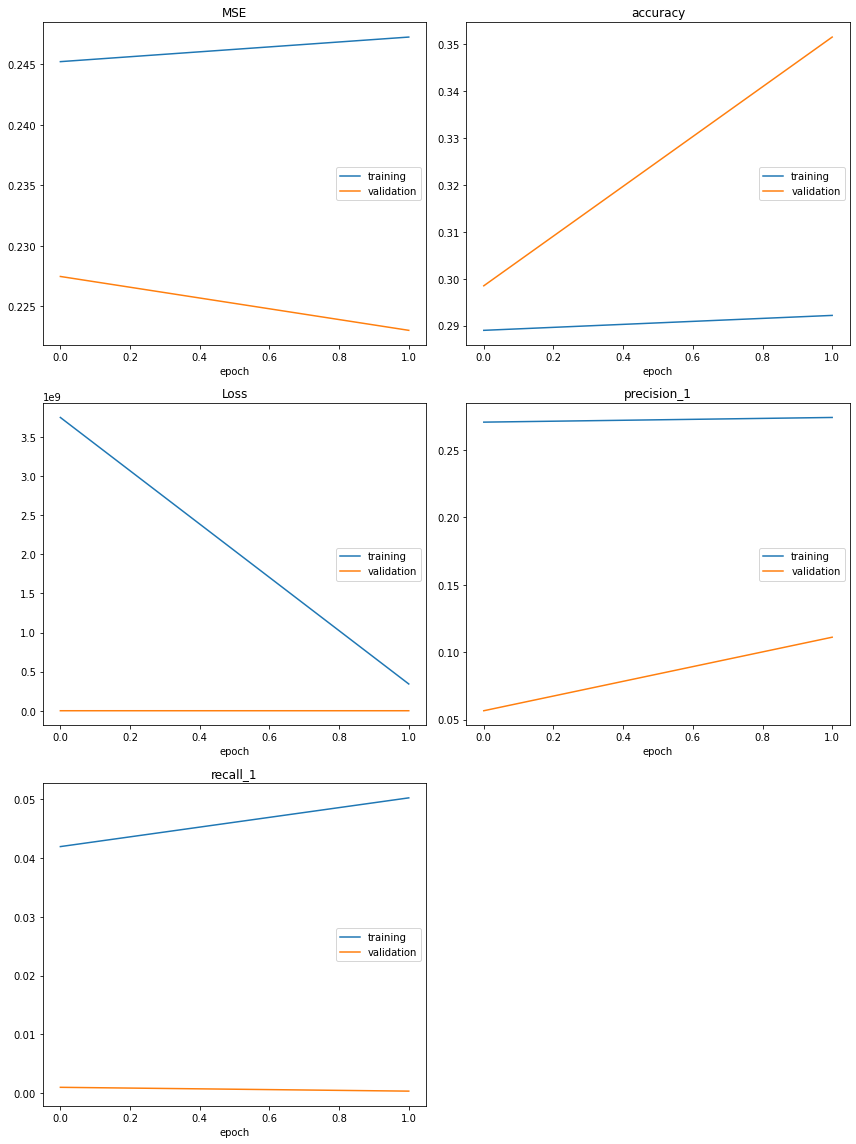

MSE
	training         	 (min:    0.245, max:    0.247, cur:    0.247)
	validation       	 (min:    0.223, max:    0.227, cur:    0.223)
accuracy
	training         	 (min:    0.289, max:    0.292, cur:    0.292)
	validation       	 (min:    0.299, max:    0.352, cur:    0.352)
Loss
	training         	 (min: 342117952.000, max: 3748410368.000, cur: 342117952.000)
	validation       	 (min: 116743.039, max: 129624.875, cur: 129624.875)
precision_1
	training         	 (min:    0.271, max:    0.274, cur:    0.274)
	validation       	 (min:    0.057, max:    0.111, cur:    0.111)
recall_1
	training         	 (min:    0.042, max:    0.050, cur:    0.050)
	validation       	 (min:    0.000, max:    0.001, cur:    0.000)
65/64 [==============================] - 39s 593ms/step - loss: 342117952.0000 - accuracy: 0.2922 - MSE: 0.2472 - precision_1: 0.2740 - recall_1: 0.0502 - val_loss: 129624.8750 - val_accuracy: 0.3516 - val_MSE: 0.2230 - val_precision_1: 0.1111 - val_recall_1: 3.2552e-04
Epoch 3/

In [ ]:

gen_args = {
    'batch_size' : batch_size,
    'shuffle' : True,
    'test' : test,
    'detrend' : detrend,
    'num_classes' : num_classes,
    'bug_testing' : False
}

train_gen = data_gen.data_generator(train_ds, **gen_args)
val_gen = data_gen.data_generator(val_ds, **gen_args)
test_gen = data_gen.data_generator(test_ds, **gen_args)

args = {'steps_per_epoch' : helper.get_steps_per_epoch(train_ds, batch_size, test),
        'epochs' : epochs,
        'validation_data' : val_gen,
        'validation_steps' : helper.get_steps_per_epoch(val_ds, batch_size, test),
        'verbose' : 1,
        'use_multiprocessing' : False, 
        'workers' : 1,
        'callbacks' : [PlotLossesKeras()]
}

model_fit = model.fit(train_gen, **args)

In [ ]:
model.evaluate_generator(generator=test_gen, steps=helper.get_steps_per_epoch(test_ds, batch_size, test))

In [ ]:
steps = len(test_ds) / batch_size
predictions = model.predict_generator(test_gen, steps)
for prediction in predictions:
    prediction_max_index  = np.where(prediction == max(prediction))
    for i in range(len(prediction)):
        if i == prediction_max_index[0]:
            prediction[i] = 1
        else:
            prediction[i] = 0

In [ ]:
import h5py
import json

def load_dataset(data_csv):
        columns = ["path", "label"]
        df = pd.read_csv(data_csv, names = columns)
        df = df.sample(frac = 1)
        return df.values



y_true = load_dataset(test_csv)[:,1]
print(y_true[0])

In [ ]:
label_dict = {'explosion':0, 'earthquake':1, 'noise':2, 'induced':3}
y_true_int = np.empty((len(y_true)), dtype=int)
for i in range(len(y_true)):
    y_true_int[i] = label_dict.get(y_true[i])

print(y_true_int)

y_true_categorical = np_utils.to_categorical(y_true_int, 3, dtype=np.int64)

In [ ]:
y_true

In [ ]:
print(confusion_matrix(y_true_categorical.argmax(axis=1), predictions[0:1234].argmax(axis=1)))

In [ ]:
helper.plot_confusion_matrix(model, test_gen, test_ds, batch_size)

In [ ]:
model.predict_generator(val_gen, 2)

In [ ]:
helper.plot_confusion_matrix(test_ds, batch_size)

In [ ]:
steps = len(test_ds)/batch_size
predictions = model.predict_generator(test_gen, steps)
predicted_classes = helper.convert_to_class(predictions)[0:(len(test_ds))]
true_classes = helper.get_class_array(test_ds, 3)
print(len(predicted_classes), len(true_classes))